In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy
# from netcal.metrics import ECE, ACE

from utils_notebook import f_probs_ovr_poe_logits_weighted, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, anytime_caching, \
                    get_metrics_for_paper, get_logits_targets_imta, get_metrics_with_error_bars

from collections import OrderedDict, Counter
import random
from typing import Dict

/home/metod/miniconda3/envs/imta/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# MODEL = "model1"
# IMTA = True
# DATASET = 'cifar10'

MODEL = "model2"
IMTA = True
DATASET = 'cifar100'


if IMTA:
    MODEL += "_IMTA"
    EPOCH = "179"
else:
    EPOCH = "299"

## 0 Load pretrained model

In [3]:
logits, targets = get_logits_targets_imta(model_name='model2_IMTA', dataset='cifar100', epoch=179, model_pretrained='model1', epoch_pretrained=299)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
acc, mono_modal, mono_correct = get_metrics_for_paper(logits, targets, model_name='IMTA')

In [5]:
mono_modal

{'IMTA': [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39],
 'IMTA-PA': [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0],
 'IMTA-CA': [6.97, 6.22, 5.08, 4.28, 3.04, 2.57, 1.96, 0.95]}

In [17]:
mono_correct

{'IMTA': [74.79, 51.15, 38.96, 33.12, 25.96, 23.39, 19.72, 13.32],
 'IMTA-PA': [16.14, 13.2, 2.06, 0.12, 0.0, 0.0, 0.0, 0.0],
 'IMTA-CA': [22.96, 16.89, 11.9, 9.97, 7.46, 6.68, 5.66, 3.97]}

In [7]:
MODEL = 'IMTA'
DATASET = 'cifar10'
MODELS = [('model1_IMTA', 179, 'model1', 299), ('model_seed_1_IMTA', 179, 'model_seed_1', 299), ('model_seed_2_IMTA', 179, 'model_seed_2', 299)]

# MODEL = 'IMTA'
# DATASET = 'cifar100'
# MODELS = [('model2_IMTA', 179, 'model1', 299), ('model_seed_1_IMTA', 179, 'model_seed_1', 299), ('model_seed_2_IMTA', 179, 'model_seed_2', 299)]

In [8]:
get_metrics_with_error_bars(model_name=MODEL, dataset=DATASET, model_list=MODELS)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

({'IMTA': ([0.8925, 0.9089, 0.9176, 0.921, 0.9235, 0.9248, 0.9245],
   [0.0018, 0.0018, 0.0004, 0.0014, 0.0023, 0.0024, 0.0026]),
  'IMTA-PA': ([0.8925, 0.9066, 0.9152, 0.9194, 0.9221, 0.9238, 0.9251],
   [0.0018, 0.0024, 0.0015, 0.0012, 0.0016, 0.0023, 0.0031]),
  'IMTA-CA': ([0.8925, 0.9052, 0.9112, 0.9153, 0.9184, 0.92, 0.9213],
   [0.0018, 0.003, 0.0013, 0.0007, 0.0012, 0.0018, 0.0019])},
 {'IMTA': ([47.1967, 20.29, 12.9467, 9.6467, 5.8733, 4.64, 2.9567, 0.9433],
   [0.1506, 0.2913, 0.1109, 0.1297, 0.2082, 0.1867, 0.1223, 0.0403]),
  'IMTA-PA': ([1.98, 1.24, 0.2467, 0.0233, 0.0, 0.0, 0.0, 0.0],
   [0.1105, 0.098, 0.0478, 0.0125, 0.0, 0.0, 0.0, 0.0]),
  'IMTA-CA': ([1.0267, 0.99, 0.8233, 0.6733, 0.42, 0.3167, 0.1733, 0.0667],
   [0.0618, 0.0432, 0.033, 0.0624, 0.0829, 0.0499, 0.0249, 0.0262])},
 {'IMTA': ([47.41, 20.4333, 13.2567, 10.2267, 6.9067, 5.8333, 4.4, 2.49],
   [0.0849, 0.3242, 0.3027, 0.2347, 0.2883, 0.2932, 0.2123, 0.1715]),
  'IMTA-PA': ([7.82, 7.2033, 5.97, 4.99, 2.77, 

## 1 Anytime performance

In [6]:
L = len(logits)
N = logits.shape[1]

In [7]:
logits.shape

torch.Size([7, 10000, 10])

In [8]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [9]:
[round(float(x), 4) for x in acc]

[0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259]

In [10]:
[round(x, 4) for x in modal_probs_decreasing(preds, probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0]

In [11]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [12]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [13]:
[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252]

In [14]:
[round(x, 4) for x in modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, 
                                            probs_poe_ovr_break_ties_generalized, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0]

In [15]:
probs_stateful = probs_stateful = anytime_caching(probs, N=N, L=L)
preds_stateful = {i: torch.argmax(probs_stateful, dim=2)[i, :] for i in range(L)}
acc_stateful = [(targets == preds_stateful[i]).sum() / len(targets) for i in range(L)]

In [16]:
[round(float(x), 4) for x in acc_stateful]

[0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199]

In [17]:
[round(x, 4) for x in modal_probs_decreasing(preds_stateful, probs_stateful, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08]

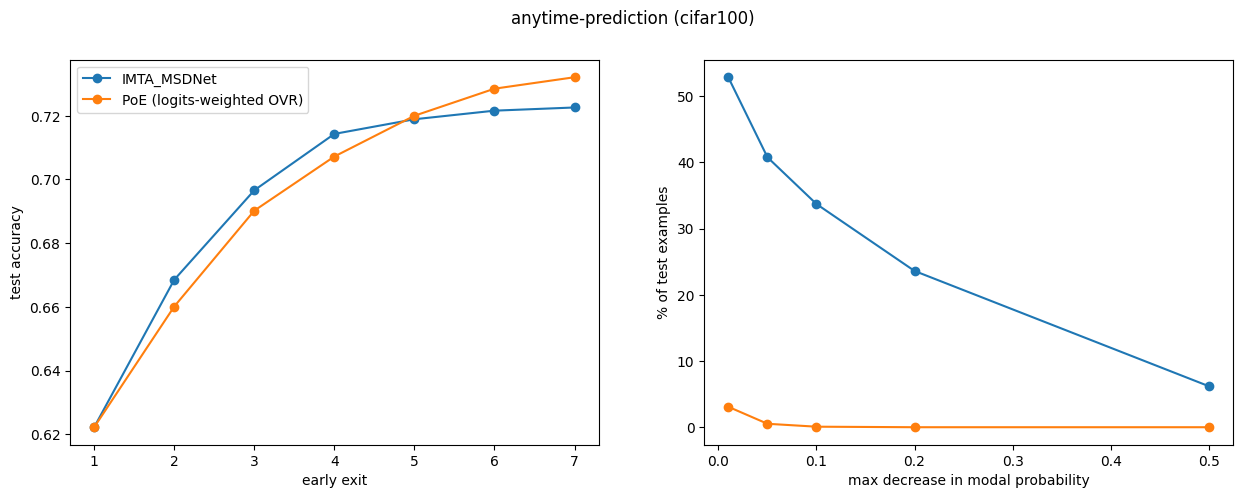

In [14]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label=f'{ARGS.arch}', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted OVR)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, f'{ARGS.arch}'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted OVR)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

In [23]:
torch.sigmoid(torch.tensor(100.))

tensor(1.)